In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
from deepsvg.svglib.geom import Point
from deepsvg.svglib.svg import SVG
from deepsvg.svglib.svg_path import SVGPath
from deepsvg.svglib.utils import to_gif

from deepsvg.difflib.tensor import SVGTensor
from deepsvg.difflib.utils import *
from deepsvg.difflib.loss import *

In [4]:
import torch.optim as optim
import IPython.display as ipd
from moviepy.editor import ImageClip, concatenate_videoclips, ipython_display

# Differentiable SVGTensor optimization
主にdifflibに関するチュートリアル。要するにdiffvgみたいなことができる（たぶんdiffvgのほうが高性能）
二つのsvg間の補完をシームレスに行うことが可能。制御点を再帰的に最適化している（diffvgと同じ）なので、それ以上のことは出来るかどうか不明。


Load a target SVG and apply the standard pre-processing.

In [5]:
svg = SVG.load_svg("docs/imgs/dolphin.svg").normalize().zoom(0.9).canonicalize().simplify_heuristic()

Convert the SVG to the differentiable SVGTensor data-structure.

In [6]:
svg_target = SVGTensor.from_data(svg.to_tensor())

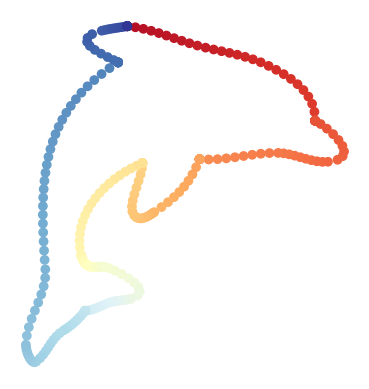

In [7]:
p_target = svg_target.sample_points()
plot_points(p_target, show_color=True)

Create an arbitrary SVG whose Bézier parameters will be optimized to match the target shape.

In [8]:
circle = SVG.unit_circle().normalize().zoom(0.9).split(8)  # split: 1/2/4/8
svg_pred = SVGTensor.from_data(circle.to_tensor())

SVGTensor enables to sample points in a differentiable way, so that the loss that will be backpropagated down to the SVG Bézier parameters.

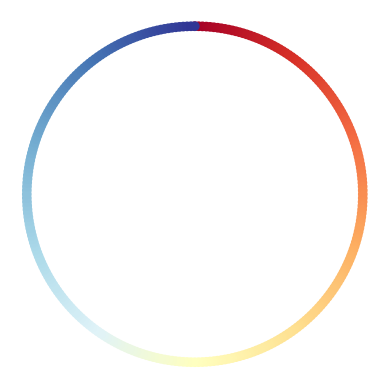

In [9]:
p_pred = svg_pred.sample_points()
plot_points(p_pred, show_color=True)

In [18]:
svg_pred.control1.requires_grad_(True)
svg_pred.control2.requires_grad_(True)
svg_pred.end_pos.requires_grad_(True);
# print(svg_pred.control1)
# print(svg_pred.control2)

In [11]:
optimizer = optim.Adam([svg_pred.control1, svg_pred.control2, svg_pred.end_pos], lr=0.1)

Write a standard gradient descent algorithm and observe the step-by-step optimization!

In [19]:
img_list = []

for i in range(150):
    optimizer.zero_grad()

    p_pred = svg_pred.sample_points()
    l = svg_emd_loss(p_pred, p_target)
    l.backward()
    optimizer.step()
    
    if i % 4 == 0:
        img = svg_pred.draw(with_points=True, do_display=False, return_png=True)
        img_list.append(img)
            
to_gif(img_list)